# Set-up<br>
This set-up assumes that the working directory (`os.curdir`) is where the notebook is.

In [95]:
import os
import sys
this_notebook_dir = os.curdir
project_root_dir = os.path.relpath(os.path.join('..', '..'), this_notebook_dir)
if project_root_dir not in sys.path:
    sys.path += [project_root_dir]
from pprint import pprint
from copy import deepcopy

# Loading data, models and explainer

In [96]:
from src.data.dataload import *
from src.models.bertmodel import *
from src.explainers.explainers import *

#data = load_agnews()
data = load_sst()
print(f'loaded dataset {data.NAME}')
bert = BertModel()
print(f'expecting location for the model file at '
      f'"{bert._get_model_filepath_for_dataset(data)}"')
bert.load_model(data)
print(f'loaded BERT model for {data.NAME}')
explainer = LimeExplainer(bert, num_samples=500)

loaded dataset sst
expecting location for the model file at "../../models/fine-tuned-bert-base-sst"
loaded BERT model for sst


# Perturbations

In [97]:
import html
from IPython.core.display import display, HTML

# Prevent special characters like & and < to cause the browser to display something other than what you intended.
def html_escape(text):
    return html.escape(text)

def visualise_weights(tokens, gradients, max_alpha=.3):
    max_alpha = max_alpha 
    highlighted_text = []
    for i in range(len(tokens)):
        weight = gradients[i]
        highlighted_text.append('<span style="background-color:rgba(135,206,250,' + str(weight / max_alpha) + ');">' + html_escape(tokens[i]) + '</span>')
    highlighted_text = ' '.join(highlighted_text)
    print(display(HTML(highlighted_text)))

In [98]:
print(f'device: {bert.device}')
train, dev, test = data.train_val_test
train.reset_index(drop=True, inplace=True)
dev.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
dev

device: cuda:0


,sentence,label
0,It 's a lovely film with lovely performances b...,3
1,"No one goes unindicted here , which is probabl...",2
2,And if you 're not nearly moved to tears by a ...,3
3,"A warm , funny , engaging film .",4
4,Uses sharp humor and insight into human nature...,4
...,...,...
1096,it seems to me the film is about the art of ri...,1
1097,It 's just disappointingly superficial -- a mo...,1
1098,The title not only describes its main characte...,1
1099,Sometimes it feels as if it might have been ma...,2


In [99]:
import scipy as sp
import scipy.stats
from src.data.perturbations import add_perturbations
from src.data.perturbations import \
    remove_commas, \
    remove_all_punctuation, \
    switch_gender, \
    strip_trailing_punct, \
    add_typo, \
    change_first_name, \
    change_last_name, \
    change_location, \
    contraction, \
    swap_adjectives

perturbation_reduction = ['strip_punct', 'remove_commas', 'remove_all_punct']
perturbation_list = perturbation_reduction + ['contraction','change_first_name','change_last_name', 'change_location', 'add_typo',
                  'switch_gender', 'swap_adj']

import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

In [100]:
def bert_detokenize(token_list):
    """
    Reverse BERT tokenization accounting for ##s representing subwords. Based on https://github.com/huggingface/transformers/issues/36
    """
    text = ' '.join(token_list)
    text = text.replace(' ##', '')
    text = text.replace("` `", "``")
    text = text.replace("' '", "''")
    return text

inds = np.arange(500)
data_fold, data_fold_name = (dev, 'dev')
perturbations_file = f'perturbations_{data.NAME}_{data_fold_name}_{len(inds)}.hdf5'
hdf5_key = 'df_perturbations'
if os.path.exists(perturbations_file):
    print('loading perturbations from', perturbations_file)
    df_perturbations = pd.read_hdf(perturbations_file, hdf5_key)
    inds = df_perturbations.index
else:
    df_perturbations = add_perturbations(
        df=data_fold.iloc[inds],
        tokenizer=bert.tokenizer,
        sentence_col_name=data.SENTENCE,
        perturbation_functions=[
            remove_commas,
            remove_all_punctuation,
            switch_gender,
            strip_trailing_punct,
            add_typo,
            contraction,
            swap_adjectives
        ]
    )
    df_perturbations_cased = add_perturbations(
        df=data_fold.iloc[inds],
        tokenizer=BertTokenizer.from_pretrained('bert-base-cased'),
        sentence_col_name=data.SENTENCE,
        perturbation_functions=[
            change_first_name,
            change_last_name,
            change_location,
        ]
    )
    def run_perturbation_loop(df, inds):
        df['orig_prediction'] = bert.predict_label_batch(df['sentence'])
        for perturbation in perturbation_list:
            if f'{perturbation}_concat' not in df.columns:
                continue
            df[f'{perturbation}_concat'] = df[f'{perturbation}_tokens'].apply(bert_detokenize)
            df[f'{perturbation}_prediction'] = bert.predict_label_batch(df[f'{perturbation}_concat'])
        return df
    def merge_perturbations(df, df_cased):
        for perturbation in ['change_first_name', 'change_last_name', 'change_location']:
            for suffix in ['tokens', 'pert_ind', 'success', 'concat', 'prediction']:
                df[f'{perturbation}_{suffix}'] = df_cased[f'{perturbation}_{suffix}'].tolist()
        return df
    df_perturbations = run_perturbation_loop(df_perturbations, inds)
    df_perturbations_cased = run_perturbation_loop(df_perturbations_cased, inds)
    df_perturbations = merge_perturbations(df_perturbations, df_perturbations_cased)
    df_perturbations.to_hdf(perturbations_file, key=hdf5_key)
    print('saving perturbations to', perturbations_file)
print(inds)
print(df_perturbations.columns)
df_perturbations.reset_index(drop=True, inplace=True)
df_perturbations

loading perturbations from perturbations_sst_dev_500.hdf5
Int64Index([   3,    6,   12,   13,   14,   16,   26,   28,   29,   30,
            ...
            1083, 1085, 1090, 1091, 1092, 1095, 1096, 1097, 1098, 1099],
           dtype='int64', length=500)
Index(['sentence', 'label', 'tokens_orig', 'remove_commas_concat',
       'remove_commas_tokens', 'remove_commas_success',
       'remove_commas_pert_ind', 'remove_all_punct_concat',
       'remove_all_punct_tokens', 'remove_all_punct_success',
       'remove_all_punct_pert_ind', 'switch_gender_concat',
       'switch_gender_tokens', 'switch_gender_success',
       'switch_gender_pert_ind', 'strip_punct_concat', 'strip_punct_tokens',
       'strip_punct_success', 'strip_punct_pert_ind', 'add_typo_concat',
       'add_typo_tokens', 'add_typo_success', 'add_typo_pert_ind',
       'change_first_name_concat', 'change_first_name_tokens',
       'change_first_name_success', 'change_first_name_pert_ind',
       'change_last_name_concat', 'c

,sentence,label,tokens_orig,remove_commas_concat,remove_commas_tokens,remove_commas_success,remove_commas_pert_ind,remove_all_punct_concat,remove_all_punct_tokens,remove_all_punct_success,...,strip_punct_prediction,remove_commas_prediction,remove_all_punct_prediction,contraction_prediction,change_first_name_prediction,change_last_name_prediction,change_location_prediction,add_typo_prediction,switch_gender_prediction,swap_adj_prediction
0,"A warm , funny , engaging film .",4,"[a, warm, ,, funny, ,, engaging, film, .]",a warm funny engaging film .,"[a, warm, , funny, , engaging, film, .]",1,"[2, 4]",a warm funny engaging film,"[a, warm, , funny, , engaging, film, ]",1,...,4,3,3,4,4,4,4,3,4,4
1,"Entertains by providing good , lively company .",3,"[entertain, ##s, by, providing, good, ,, livel...",entertains by providing good lively company .,"[entertain, ##s, by, providing, good, , lively...",1,[5],entertains by providing good lively company,"[entertain, ##s, by, providing, good, , lively...",1,...,3,3,3,3,3,3,3,3,3,3
2,The band 's courage in the face of official re...,3,"[the, band, ', s, courage, in, the, face, of, ...",the band ' s courage in the face of official r...,"[the, band, ', s, courage, in, the, face, of, ...",1,[13],the band s courage in the face of official re...,"[the, band, , s, courage, in, the, face, of, o...",1,...,3,3,3,3,3,3,3,3,3,3
3,Although German cooking does not come readily ...,3,"[although, german, cooking, does, not, come, r...",although german cooking does not come readily ...,"[although, german, cooking, does, not, come, r...",1,[17],although german cooking does not come readily ...,"[although, german, cooking, does, not, come, r...",1,...,3,3,3,3,3,3,3,3,3,3
4,A beguiling splash of pastel colors and pranki...,4,"[a, beg, ##uil, ##ing, splash, of, paste, ##l,...",a beguiling splash of pastel colors and pranki...,"[a, beg, ##uil, ##ing, splash, of, paste, ##l,...",0,None,a beguiling splash of pastel colors and pranki...,"[a, beg, ##uil, ##ing, splash, of, paste, ##l,...",1,...,4,3,4,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,... Designed to provide a mix of smiles and te...,1,"[., ., ., designed, to, provide, a, mix, of, s...",. . . designed to provide a mix of smiles and ...,"[., ., ., designed, to, provide, a, mix, of, s...",1,[12],designed to provide a mix of smiles and tea...,"[, , , designed, to, provide, a, mix, of, smil...",1,...,1,1,1,1,1,1,1,1,1,1
496,it seems to me the film is about the art of ri...,1,"[it, seems, to, me, the, film, is, about, the,...",it seems to me the film is about the art of ri...,"[it, seems, to, me, the, film, is, about, the,...",0,None,it seems to me the film is about the art of ri...,"[it, seems, to, me, the, film, is, about, the,...",0,...,1,1,1,1,1,1,1,1,1,1
497,It 's just disappointingly superficial -- a mo...,1,"[it, ', s, just, disappointing, ##ly, superfic...",it ' s just disappointingly superficial - - a ...,"[it, ', s, just, disappointing, ##ly, superfic...",1,"[21, 25]",it s just disappointingly superficial a mov...,"[it, , s, just, disappointing, ##ly, superfici...",1,...,1,1,1,1,1,1,1,1,1,1
498,The title not only describes its main characte...,1,"[the, title, not, only, describes, its, main, ...",the title not only describes its main characte...,"[the, title, not, only, describes, its, main, ...",1,[8],the title not only describes its main characte...,"[the, title, not, only, describes, its, main, ...",1,...,1,1,1,1,1,1,1,2,1,1


In [101]:
def run_lime_bert_loop(df, inds, saved, save_filename, max_alpha=.8, K=5, checkpointing=True):
    results = saved
    for r in np.arange(len(inds)):
        sentence = {}
        tokens = {}
        success = {}
        pert_indices = {}
        scores = {}
        prediction = {}
        comparison = {}
        top_K_intersect = {}
        exp_indices= {} #to store indices returned by the explainer
        print('r', r)
        sentence['orig'] = df.sentence[r]
        print(sentence['orig'])
        if r not in results:
            results[r] = {}
        if 'orig' not in results[r]:
            results[r]['orig'] = {}
        if 'exp' not in results[r]['orig']:
            X = explainer.explain_instance(sentence['orig'])
            results[r]['orig']['exp'] = X
        else:
            X = results[r]['orig']['exp']
        tokens['orig'] = X[3]
        scores['orig'] = np.array(X[0])
        prediction['orig'] = X[1]
        exp_indices['orig'] = X[2]
        print('Original: ', sentence['orig'])
        # creating dict for easier reference
        for perturbation in perturbation_list:
            sentence[perturbation] = df[f'{perturbation}_concat'].iloc[r]
            tokens[perturbation] = df[f'{perturbation}_tokens'].iloc[r]
            success[perturbation] = df[f'{perturbation}_success'].iloc[r]
            pert_indices[perturbation] = df[f'{perturbation}_pert_ind'].iloc[r]
            prediction[perturbation] = df[f'{perturbation}_prediction'].iloc[r]
            print(f'Perturbed {perturbation}: ', sentence[perturbation])
            if prediction[perturbation] != prediction['orig']:
                print('DIFFERENT PREDICTION')
            if success[perturbation] != 0 and prediction[perturbation] == prediction['orig']:
                try:
                    if r not in results:
                        results[r] = {}
                    if perturbation not in results[r]:
                        results[r][perturbation] = {}
                    if 'exp' not in results[r][perturbation]:
                        X = explainer.explain_instance(sentence[perturbation])
                        results[r][perturbation]['exp'] = X
                    else:
                        X = results[r][perturbation]['exp']
                    scores[perturbation] = np.array(X[0])
                    prediction[perturbation] = X[1]
                    tokens[perturbation] = X[3]
                    exp_indices[perturbation] = X[2]
                except:
                    print('\n'+'numerical overflow')
                    print(perturbation)
                    print(sentence[perturbation])
                    scores[perturbation] = scores['orig']
                    prediction[perturbation] = prediction['orig']
                    tokens[perturbation] = tokens['orig']
                    exp_indices[perturbation]=exp_indices['orig']
        for perturbation in perturbation_list:
            #COMPARE ONLY IF SENTENCE WAS CHANGED
            if success[perturbation] == 0:
                comparison[perturbation] = None
                continue
            #COMPARE ONLY IF PREDICTION NOT CHANGED
            elif prediction[perturbation] != prediction['orig']:
                comparison[perturbation] = None
                continue
            #COMPARE ONLY IF WEIGHTS ARE ABOVE THRESHOLD SIZE
            elif max(scores['orig'])<0.05:
                comparison[perturbation] = None
                continue
            else:
                #COMPARE ONLY IF UN-IMPORTANT TOKEN CHANGED
                #original top_5 tokens
                top_5_orig = set(tokens['orig'][:5])
                #check if these were changed in perturbed sentence
                new_tokens = set(tokens[perturbation])
                intersections = top_5_orig.intersection(new_tokens)
                if len(intersections)<5:
                    comparison[perturbation] = None
                    continue
                else:
                    #DELETED TOKENS ARE PUNCTUATION, COMMMAS WHICH LIME IGNORES - SKIP THIS PERTURBATION
                    #BUT DON'T SKIP ADJUSTING INDICES WHEN SWAPPING ADJECTIVES
                    if perturbation == 'swap_adj': # perturbation category 2
                        orig_score_swapped = deepcopy(scores['orig'])
                        #swapped words - need to get from original sentence
                        for i in range(len(pert_indices[perturbation][::2])):
                            index_adj_1 = pert_indices[perturbation][i]
                            index_adj_2 = pert_indices[perturbation][i+1]
                            token_adj_1 = df.tokens_orig.iloc[r][index_adj_1]
                            token_adj_2 = df.tokens_orig.iloc[r][index_adj_2]
                            print(token_adj_1,token_adj_2)
                        #find the corresponding LIME indices
                            index_adj_1 = tokens['orig'].index(token_adj_1)
                            index_adj_2 = tokens['orig'].index(token_adj_2)
                            score_adj_1 = scores['orig'][index_adj_1]
                            score_adj_2 = scores['orig'][index_adj_2]
                            orig_score_swapped[index_adj_1] = score_adj_2
                            orig_score_swapped[index_adj_2] = score_adj_1
                        orig_score_for_comparison = orig_score_swapped
                    else: # remaining perturbations
                        orig_score_for_comparison = scores['orig']
                    if len(orig_score_for_comparison) != len(scores[perturbation]):
                        print('length not matching after perturbation: ',perturbation)
                        comparison[perturbation] = None
                    else:
                        #sort the score arrays according to position - as they were originally sorted by weights
                        #first compute top-K intersections
                        orig_inds_sort = np.argsort(np.abs(scores['orig']))
                        top_K_orig = list(set([tokens['orig'][i] for i in orig_inds_sort][:K]))
#                        top_K_orig = list(set(tokens['orig'][:K]))
                        pert_inds_sort = np.argsort(np.abs(scores[perturbation]))
#                        top_K_perturb = list(set(tokens[perturbation][:K]))
                        top_K_perturb = list(set([tokens[perturbation][i] for i in pert_inds_sort][:K]))
                        intersections = set(top_K_orig).intersection(top_K_perturb)
                        top_K_intersect[perturbation] = len(intersections)/K
                        results[r][perturbation][f'top_{K}_intersect'] = top_K_intersect[perturbation]
                       # print(perturbation)
                       # print(sentence[perturbation])
                        print('\n'+perturbation)
                        print(top_K_orig)
                        print(top_K_perturb)
                        print('top K: ',len(intersections)/K)
                        #print(perturbation,':  ',tokens['orig'][:5],tokens[perturbation][:5])
                        #print(perturbation,':  ',scores['orig'][:5],scores[perturbation][:5])
                        zipped_lists = zip(exp_indices['orig'], orig_score_for_comparison, tokens['orig'])
                        sorted_tuples = sorted(zipped_lists)
                        tuples = zip(*sorted_tuples)
                        orig_indices, orig_scores,orig_tokens = [list(t) for t in  tuples]
                        results[r][perturbation]['orig_indices'] = orig_indices
                        results[r][perturbation]['orig_scores'] = orig_scores
                        results[r][perturbation]['orig_tokens'] = orig_tokens
                        zipped_lists = zip(exp_indices[perturbation],scores[perturbation],tokens[perturbation])
                        sorted_tuples = sorted(zipped_lists)
                        tuples = zip(*sorted_tuples)
                        _, perturb_scores, perturb_tokens = [list(t) for t in  tuples]
                        results[r][perturbation]['perturb_scores'] = perturb_scores
                        results[r][perturbation]['perturb_tokens'] = perturb_tokens
                        #print(orig_tokens[:20])
                        #print(perturb_tokens[:20])
                        #print(['{:.3f}'.format(x) for x in orig_scores])
                        #print(['{:.3f}'.format(x) for x in perturb_scores])
                        comparison[perturbation] = sp.stats.spearmanr(orig_scores, perturb_scores)[0]
                        results[r][perturbation]['spearman'] = comparison[perturbation]
                        results[r][perturbation]['sentence'] = sentence[perturbation]
                        results[r][perturbation]['sentence_orig'] = sentence['orig']
                        #print(comparison[perturbation])
                        print('Spearman: ',comparison[perturbation])
                        if (comparison[perturbation] < 0.7):
                           # print(comparison[perturbation]==None,'XX')
                            #print('Sentence: ', sentence[perturbation])
                            visualise_weights(orig_tokens, orig_scores, max_alpha=max_alpha)
                            visualise_weights(perturb_tokens, perturb_scores, max_alpha=max_alpha)
                            #print(comparison[perturbation],perturbation)
                            #print(['{:.3f}'.format(x) for x in orig_scores])
                            #print(['{:.3f}'.format(x) for x in perturb_scores])
        if (r + 1) % 5 == 0 and checkpointing:
            print('saving results...')
            with open(f'{save_filename}.tmp', 'wb') as f:
                pkl = pickle.dumps(results)
                gz = gzip.compress(pkl)
                f.write(gz)
            os.rename(f'{save_filename}.tmp', save_filename)
            print('saved results')
    return results

In [103]:
import gzip
import pickle
import json

#saved_fname = f'bert_lime_{data.NAME}_dev_5000_chk.pkl.gz'
saved_fname = f'bert_lime_{data.NAME}_dev_{len(inds)}.pkl.gz'
saved = {}
K = 5
if os.path.exists(saved_fname):
    with open(saved_fname, 'rb') as f:
        j = gzip.decompress(f.read())
    saved = pickle.loads(j)
    print('loaded saved results', saved_fname)
else:
    saved = run_lime_bert_loop(df_perturbations, inds=inds, saved=saved, save_filename=saved_fname, checkpointing=False)
#results = run_lime_bert_loop(df_perturbations, inds=inds, saved=saved, save_filename=None, checkpointing=False)
#with open(f'{saved_fname}', 'wb') as f:
#    pkl = pickle.dumps(results)
#    gz = gzip.compress(pkl)
#    f.write(gz)
#    print('written')
results = saved
import itertools
set(itertools.chain(*results.values()))

loaded saved results bert_lime_sst_dev_500.pkl.gz


{'add_typo',
 'change_first_name',
 'change_last_name',
 'change_location',
 'contraction',
 'orig',
 'remove_all_punct',
 'remove_commas',
 'strip_punct',
 'swap_adj',
 'switch_gender'}

In [104]:
vault = []
print(results.keys())
for i, info in tqdm(results.items()):
    for perturbation in info:
        pinfo = info[perturbation]
        if type(pinfo) != dict:
#            print(i, info, perturbation, pinfo)
            continue
        if 'spearman' not in pinfo:
            continue
        if 'orig_tokens' not in pinfo:
            continue
        vault += [dict(
            index=i,
            pinfo=pinfo,
            perturbation=perturbation,
            sentence_orig=pinfo['sentence_orig'],
            sentence=pinfo['sentence'],
            explanation=pinfo['exp'],
            topk=pinfo['top_5_intersect'],
            spearman=pinfo['spearman'],
        )]
N = min(len(vault), 10)
sorted_spearman_N = sorted(vault, key=lambda v: v['spearman'])[:N]
sorted_topk_N = sorted(vault, key=lambda v: v['topk'])[:N]
# spearman stuff
for i in range(N):
    v = sorted_spearman_N[i]
#    v = sorted_topk_N[i]
    print('-'*100)
    print('index', v['index'])
    print('top K: ', v['topk'])
    print('Spearman: ', v['spearman'])
    print('SENTENCE ', v['pinfo']['sentence_orig'])
    orig_scores = np.array(v['pinfo']['orig_scores'])
    perturb_scores = np.array(v['pinfo']['perturb_scores'])
    def amend_scores(s):
        #vmax = max(orig_scores.max(), perturb_scores.max())
        #vmin = min(orig_scores.min(), perturb_scores.min())
        #normalized = (s - vmin) / (vmax - vmin)
        #normalized = np.log(1.05 + normalized * (np.e - 1.05))
        #return normalized
        return s
    orig_func = lambda t: t.lower() if 'change' not in v['perturbation'] else t
    visualise_weights([orig_func(t) for t in v['pinfo']['orig_tokens']], amend_scores(orig_scores), max_alpha=.8)
    print(v["perturbation"])
    print(f'PERTURBED', v['pinfo']['sentence'])
    visualise_weights(v['pinfo']['perturb_tokens'], amend_scores(perturb_scores), max_alpha=.8)
    K = min(10, len(v['pinfo']['perturb_tokens']), len(v['pinfo']['orig_tokens']))
    # orig tokens
    orig_inds = range(len(orig_scores))
    orig_inds = sorted(orig_inds, key=lambda i: np.abs(orig_scores[i]), reverse=True)[:K]
    print([f'{v["pinfo"]["orig_tokens"][i]}' for i in orig_inds])
    print(['%.3f' % orig_scores[i] for i in orig_inds])
    # perturb tokens
    perturb_inds = range(len(perturb_scores))
    perturb_inds = sorted(perturb_inds, key=lambda i: np.abs(perturb_scores[i]), reverse=True)[:K]
    print([f'{v["pinfo"]["perturb_tokens"][i]}' for i in perturb_inds])
    print(['%.3f' % perturb_scores[i] for i in perturb_inds])

100%|██████████| 500/500 [00:00<00:00, 166506.71it/s]

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

None
remove_all_punct
PERTURBED a by  the  numbers patient  doctor pic that covers all the usual ground


None
['all', 'patient', 'the', 'that', 'covers', 'usual', 'by', 'ground', 'numbers', 'pic']
['-0.065', '0.059', '-0.048', '-0.034', '0.026', '-0.025', '-0.014', '-0.010', '0.009', '0.008']
['pic', 'that', 'a', 'covers', 'by', 'all', 'numbers', 'usual', 'the', 'ground']
['0.036', '-0.022', '-0.020', '-0.019', '0.018', '-0.017', '0.015', '0.013', '0.008', '-0.007']
----------------------------------------------------------------------------------------------------
index 417
top K:  0.4
Spearman:  0.2087912087912088
SENTENCE  The film 's tone and pacing are off almost from the get-go .


None
add_typo
PERTURBED the fil m' s tone and pacing are off almost from the get - go .


None
['off', 'pacing', 'and', 'are', 'get', 'almost', 'from', 'the', 's', 'film']
['0.253', '0.181', '-0.083', '0.049', '0.047', '0.044', '0.041', '-0.026', '-0.014', '-0.009']
['pacing', 'off', 'from', 'and', 'get', 'almost', 's', 'are', 'the', 'tone']
['0.219', '0.135', '0.041', '-0.039', '0.039', '0.037', '-0.029', '0.023', '0.018', '-0.013']
----------------------------------------------------------------------------------------------------
index 226
top K:  0.2
Spearman:  0.40751879699248117
SENTENCE  `` Mostly Martha '' is a bright , light modern day family parable that wears its heart on its sleeve for all to see .


None
remove_all_punct
PERTURBED   mostly martha   is a bright  light modern day family parable that wears its heart on its sleeve for all to see 


None
['bright', 'light', 'heart', 'sleeve', 'to', 'family', 'its', 'see', 'all', 'that']
['0.067', '0.053', '0.042', '0.032', '-0.027', '0.023', '0.016', '-0.013', '-0.012', '-0.012']
['bright', 'heart', 'parable', 'its', 'family', 'martha', 'light', 'wears', 'mostly', 'a']
['0.141', '0.114', '-0.096', '0.081', '0.062', '0.060', '0.059', '-0.055', '-0.036', '0.034']
----------------------------------------------------------------------------------------------------
index 325
top K:  0.2
Spearman:  0.409373235460192
SENTENCE  A TV style murder mystery with a few big screen moments ( including one that seems to be made for a different film altogether ) .


None
add_typo
PERTURBED a tv style murder mystery with a few big screen moments ( including one that seems to be made fo ra different film altogether ) .


None
['mystery', 'a', 'few', 'with', 'different', 'murder', 'altogether', 'screen', 'seems', 'made']
['0.088', '0.080', '0.053', '-0.033', '0.030', '-0.027', '-0.025', '-0.025', '0.024', '-0.019']
['mystery', 'few', 'a', 'screen', 'with', 'different', 'murder', 'style', 'to', 'altogether']
['0.078', '0.063', '0.057', '-0.041', '-0.031', '0.029', '-0.023', '-0.020', '-0.019', '-0.019']
----------------------------------------------------------------------------------------------------
index 130
top K:  0.4
Spearman:  0.41818181818181815
SENTENCE  It proves quite compelling as an intense , brooding character study .


None
remove_commas
PERTURBED it proves quite compelling as an intense  brooding character study .


None
['compelling', 'quite', 'intense', 'brooding', 'character', 'proves', 'an', 'It', 'study', 'as']
['0.054', '0.043', '0.037', '0.037', '0.026', '0.019', '0.014', '0.003', '0.001', '0.000']
['compelling', 'character', 'an', 'intense', 'proves', 'as', 'it', 'study', 'quite', 'brooding']
['0.111', '0.034', '0.034', '0.032', '0.017', '-0.012', '0.006', '0.005', '0.005', '0.005']
----------------------------------------------------------------------------------------------------
index 54
top K:  0.6
Spearman:  0.4342179559570865
SENTENCE  ... a story we have n't seen on the big screen before , and it 's a story that we as Americans , and human beings , should know .


None
remove_all_punct
PERTURBED    a story we have n  t seen on the big screen before  and it  s a story that we as americans  and human beings  should know 


None
['t', 'we', 'it', 'story', 'and', 'before', 'should', 'a', 'big', 'human']
['-0.123', '0.076', '0.060', '0.056', '0.052', '0.043', '0.038', '0.032', '0.023', '0.022']
['and', 'story', 't', 'know', 'a', 'we', 'before', 'big', 'should', 'on']
['0.152', '0.105', '-0.090', '0.083', '0.062', '0.061', '-0.041', '0.041', '-0.026', '-0.020']
----------------------------------------------------------------------------------------------------
index 130
top K:  0.4
Spearman:  0.4424242424242424
SENTENCE  It proves quite compelling as an intense , brooding character study .


None
remove_all_punct
PERTURBED it proves quite compelling as an intense  brooding character study 


None
['compelling', 'quite', 'intense', 'brooding', 'character', 'proves', 'an', 'It', 'study', 'as']
['0.054', '0.043', '0.037', '0.037', '0.026', '0.019', '0.014', '0.003', '0.001', '0.000']
['compelling', 'an', 'intense', 'character', 'as', 'study', 'brooding', 'it', 'proves', 'quite']
['0.158', '0.050', '0.043', '0.037', '-0.024', '0.020', '-0.008', '-0.007', '0.006', '0.003']
----------------------------------------------------------------------------------------------------
index 291
top K:  0.6
Spearman:  0.4424242424242424
SENTENCE  So much facile technique , such cute ideas , so little movie .


None
add_typo
PERTURBED so much facile technique , such cute ideas , so little movi e.


None
['facile', 'little', 'cute', 'ideas', 'so', 'technique', 'such', 'So', 'movie', 'much']
['0.205', '0.203', '-0.083', '0.059', '0.057', '0.033', '0.031', '-0.015', '-0.014', '0.006']
['facile', 'cute', 'little', 'so', 'movi', 'ideas', 'such', 'technique', 'e', 'much']
['0.256', '-0.204', '0.131', '0.116', '-0.091', '0.088', '0.065', '0.041', '-0.032', '0.020']
----------------------------------------------------------------------------------------------------
index 492
top K:  0.4
Spearman:  0.4735294117647058
SENTENCE  The humor is n't as sharp , the effects not as innovative , nor the story as imaginative as in the original .


None
add_typo
PERTURBED the humor is n ' t as sharp , the effects not as innovative , nor the story as imaginative as i nthe original .


None
['t', 'nor', 'not', 'as', 'is', 'innovative', 'humor', 'n', 'original', 'the']
['0.146', '0.132', '0.113', '0.052', '0.036', '0.025', '0.023', '0.021', '0.016', '-0.015']
['nor', 't', 'not', 'as', 'is', 'innovative', 'n', 'humor', 'sharp', 'effects']
['0.143', '0.132', '0.126', '0.055', '0.035', '0.026', '0.023', '0.022', '0.015', '0.014']
----------------------------------------------------------------------------------------------------
index 71
top K:  0.4
Spearman:  0.5272727272727272
SENTENCE  A subtle and well-crafted ( for the most part ) chiller .


None
remove_all_punct
PERTURBED a subtle and well  crafted  for the most part  chiller 


None
['subtle', 'part', 'and', 'well', 'most', 'for', 'A', 'chiller', 'crafted', 'the']
['0.126', '0.059', '-0.040', '0.039', '0.038', '0.025', '-0.005', '-0.004', '0.004', '0.004']
['subtle', 'most', 'crafted', 'and', 'for', 'the', 'well', 'part', 'chiller', 'a']
['0.118', '0.054', '-0.027', '-0.025', '0.024', '0.024', '-0.017', '0.015', '-0.003', '0.003']


In [92]:
# manual check

lexplainer = LimeExplainer(bert, num_samples=2000)

V = sorted_topk_N[-1]
s = V['pinfo']['sentence_orig']
p = V['pinfo']['sentence']
perturbation = V['perturbation']

print('ORIGINAL')
print(s)
print(perturbation)
print('PERTURBATION')
print(p)

for i in range(3):
    print('-' * 100)
    orig_scores, orig_pred, orig_indices, orig_tokens = lexplainer.explain_instance(s)
    pert_scores, pert_pred, pert_indices, pert_tokens = lexplainer.explain_instance(p)
    print(s)
    print(p)

    N = min(10, len(orig_scores), len(pert_scores))
    orig_inds = sorted(range(len(orig_scores)), key=lambda i: orig_scores[i], reverse=True)[:K]
    pert_inds = sorted(range(len(pert_scores)), key=lambda i: pert_scores[i], reverse=True)[:K]

    print('TOP WEIGHTS')
    print([orig_tokens[i] for i in orig_inds])
    print(['%.3f' % orig_scores[i] for i in orig_inds])
    print([pert_tokens[i] for i in pert_inds])
    print(['%.3f' % pert_scores[i] for i in pert_inds])

    print('APPROPRIATE INDICES')
    orig_indices = np.argsort(orig_indices)
    print([orig_tokens[i] for i in orig_indices])
    pert_indices = np.argsort(pert_indices)
    print([pert_tokens[i] for i in pert_indices])
    print('Spearman', sp.stats.spearmanr([orig_scores[i] for i in orig_indices], [pert_scores[i] for i in pert_indices])[0])

del lexplainer

ORIGINAL
Reuters - Weak tech stocks dragged Asian shareslower on Thursday, outweighing the positive impact on exportersof a dollar rebound, and knocking 1.2 percent off Tokyo sharesto threaten the biggest one-day fall since Nov. 22.
remove_all_punct
PERTURBATION
reuters  weak tech stocks dragged asian shareslower on thursday  outweighing the positive impact on exportersof a dollar rebound  and knocking 1  2 percent off tokyo sharesto threaten the biggest one  day fall since nov  22 
----------------------------------------------------------------------------------------------------


 42%|████▏     | 52/125 [00:44<01:02,  1.17it/s]


KeyboardInterrupt: 

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

COLORS = [
    '#9966CC',  # (m) ametist
    '#007FFF',  # (b) azure
    '#84DE02',  # (g) alien ampit
    '#FFA812',  # (y) dark tangerine
    '#FD3F92',  # (r) french fuchsia
    '#B87333',  # (b) copper
    '#5F9EA0',  # cadet blue
    '#3B444B',  # (k) arsenic
    'c',
    'm'
]
plt.style.use('seaborn-white')
FONTSTYLE = lambda sz: dict(size=sz,
                            family='monospace')

FixedFormatter should only be used together with FixedLocator


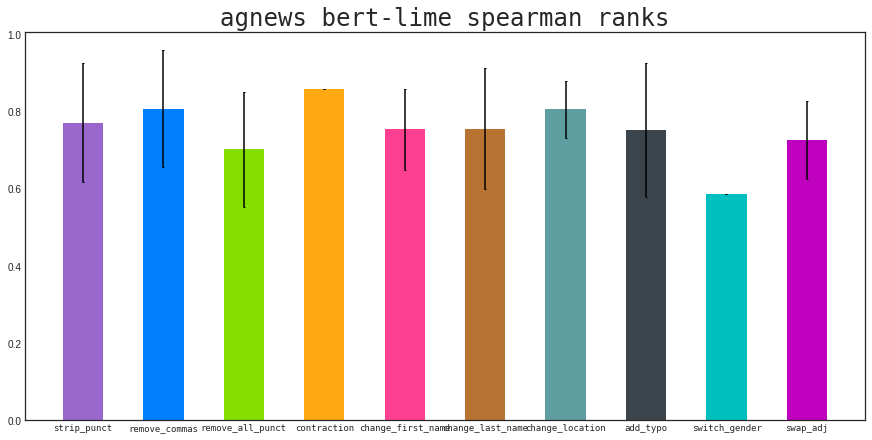

FixedFormatter should only be used together with FixedLocator


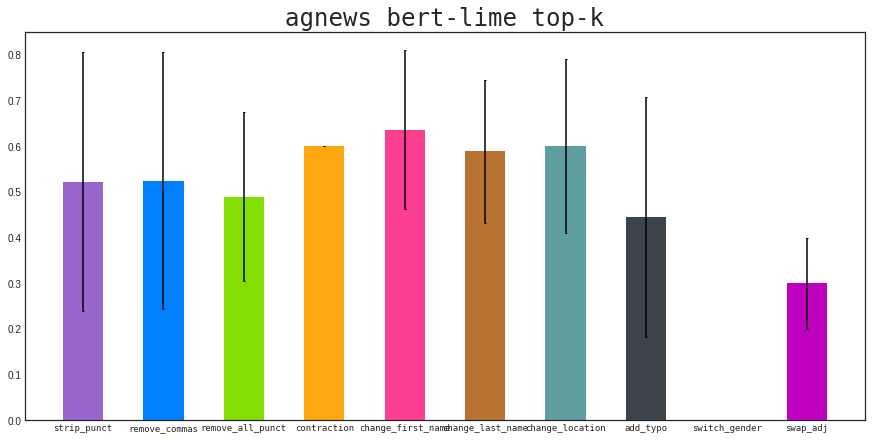

FixedFormatter should only be used together with FixedLocator


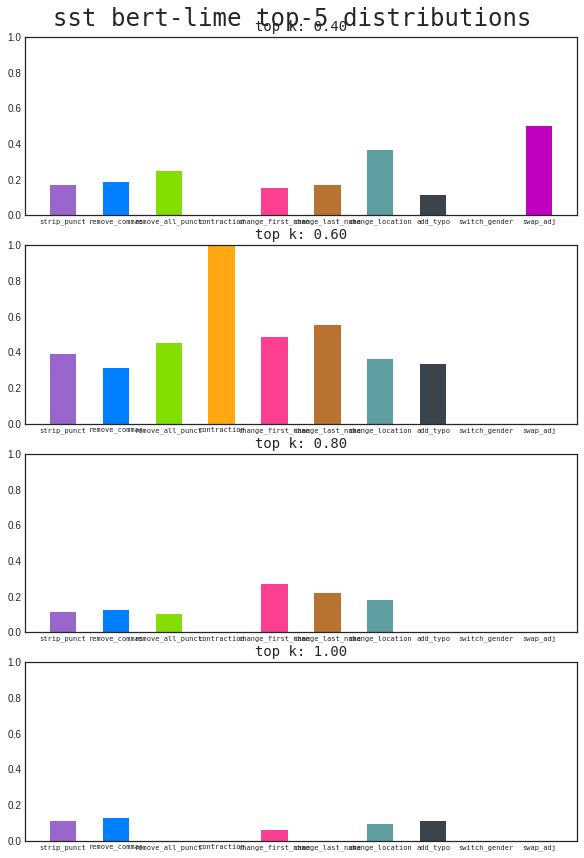

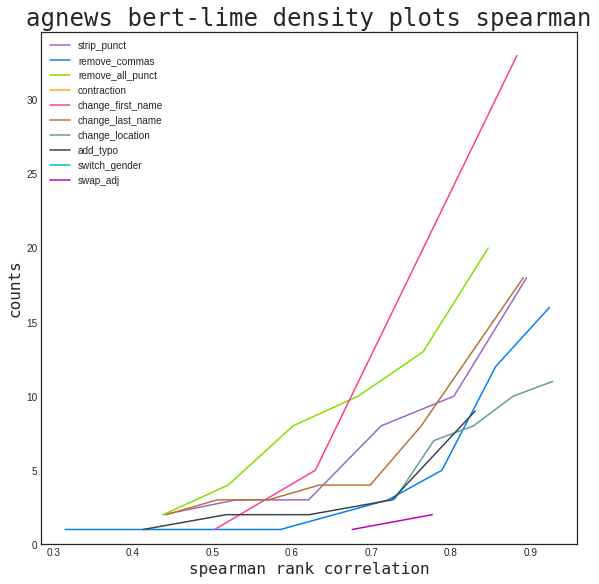

\begin{tabular}{|c|c|c|}
\hline
               \  & top-5-intersection & Spearman's rank cor. coeff. \\\hline 
      strip\_punct &     $0.52 \pm 0.3$ &              $0.77 \pm 0.2$ \\\hline 
    remove\_commas &     $0.53 \pm 0.3$ &              $0.81 \pm 0.2$ \\\hline 
 remove\_all\_punct &     $0.49 \pm 0.2$ &              $0.70 \pm 0.1$ \\\hline 
      contraction &     $0.60 \pm 0.0$ &              $0.86 \pm 0.0$ \\\hline 
change\_first\_name &     $0.64 \pm 0.2$ &              $0.75 \pm 0.1$ \\\hline 
 change\_last\_name &     $0.59 \pm 0.2$ &              $0.76 \pm 0.2$ \\\hline 
  change\_location &     $0.60 \pm 0.2$ &              $0.81 \pm 0.1$ \\\hline 
         add\_typo &     $0.44 \pm 0.3$ &              $0.75 \pm 0.2$ \\\hline 
    switch\_gender &     $0.00 \pm 0.0$ &              $0.59 \pm 0.0$ \\\hline 
         swap\_adj &     $0.30 \pm 0.1$ &              $0.73 \pm 0.1$ \\\hline 
\end{tabular}



In [87]:
buckets = {}
for i, info in results.items():
    for perturbation in info:
        pinfo = info[perturbation]
        if 'spearman' not in pinfo:
            continue
        if 'orig_tokens' not in pinfo:
            continue
        if perturbation not in buckets:
            buckets[perturbation] = dict(
                count=0,
                spearmans=[],
                topk=[],
            )
        buckets[perturbation]['count'] += 1
        buckets[perturbation]['spearmans'] += [pinfo['spearman']]
        buckets[perturbation]['topk'] += [pinfo['top_5_intersect']]

# spearman graph
plt.figure(figsize=(12,6))
plt.title(f'{data.NAME} bert-lime spearman ranks', **FONTSTYLE(24))
xs = [p for p in perturbation_list if p in buckets]
xvalues = [buckets[x] for x in xs]
ys = [np.mean(v['spearmans']) for v in xvalues]
es = [np.std(v['spearmans']) for v in xvalues]
plt.bar(xs, ys, width=.5, yerr=es, color=COLORS, error_kw=dict(
    capsize=1
))
plt.gca().set_xticklabels(labels=xs, fontproperties=FONTSTYLE(9))
plt.tight_layout(pad=.3)
plt.show()
plt.close()
# top-k graph
plt.figure(figsize=(12, 6))
plt.title(f'{data.NAME} bert-lime top-k', **FONTSTYLE(24))
ys = [np.mean(v['topk']) for v in xvalues]
es = [np.std(v['topk']) for v in xvalues]
plt.bar(xs, ys, width=.5, yerr=es, color=COLORS, error_kw=dict(
    capsize=1
))
plt.gca().set_xticklabels(labels=xs, fontproperties=FONTSTYLE(9))
plt.tight_layout(pad=.3)
plt.show()
plt.close()
# for each value of top-k
nr, nc = 4, 1
K=5
fig, axs = plt.subplots(nr, nc, figsize=(8*nc, 3*nr))
plt.suptitle(f'sst bert-lime top-{K} distributions', **FONTSTYLE(24))
ylimit=0
for k in range(K+1):
    ys = [len([t for t in v['topk'] if np.allclose(t, 1/K*k)]) / len(v['topk']) for v in xvalues]
    ylimit = max(ylimit, np.max(ys))
ylimit = min(1, ylimit + 0.1)
for i in range(nr):
    for j in range(nc):
        k = i * nc + j + 2
        #ax = axs[i,j]
        ax = axs[i]
        ys = [len([t for t in v['topk'] if np.allclose(t, 1/K*k)]) / len(v['topk']) for v in xvalues]
        ax.set_title(f'top k: {"%.2f"%(1/K*k)}', **FONTSTYLE(14))
        ax.set_ylim(0, ylimit)
        ax.bar(xs, ys, width=.5, color=COLORS)
        ax.set_xticklabels(labels=xs, fontproperties=FONTSTYLE(7))
plt.tight_layout(pad=.3)
plt.show()
plt.close()
# density plots for spearman
plt.figure(figsize=(8,8))
bucketkeys = list(buckets.keys())
plt.title(f'{data.NAME} bert-lime density plots spearman', **FONTSTYLE(24))
for ind, pert in enumerate([p for p in perturbation_list if p in buckets]):
    if pert not in buckets:
        continue
    sns.histplot(buckets[pert]['spearmans'],
                 multiple='stack', element='poly', stat='count', bins='auto',
                 color=COLORS[ind], label=pert, fill=False, cumulative=True,)
plt.ylim(bottom=0)
plt.xlabel('spearman rank correlation', **FONTSTYLE(16))
plt.ylabel('counts', **FONTSTYLE(16))
plt.legend(loc='best')
plt.tight_layout(pad=.3)
plt.show()
plt.close()
# tables
results_table = pd.DataFrame({
    "\ ": xs,
    'top-5-intersection': ["$%.2f \pm %.1f$" % (np.mean(v['topk']), np.std(v['topk']))
                                                for v in xvalues],
    "Spearman's rank cor. coeff.": ["$%.2f \pm %.1f$" % (np.mean(v['spearmans']), np.std(v['spearmans']))
                                                         for v in xvalues],
})
rules = [
    ('lll', '|c|c|c|'),
    ('toprule', 'hline'),
    ('\\bottomrule\n', ''),
    ('\\midrule\n', ''),
    ('_', '\_'),
    ('\\\\', '\\\\\\hline '),
]
tabular = results_table.to_latex(index=False, escape=False)
for rfrom, rto in rules:
    tabular = tabular.replace(rfrom, rto)
print(tabular)

In [88]:
sst_perturbations = pd.read_hdf(f'perturbations_{DatasetSST.NAME}_dev_{len(inds)}.hdf5', key=hdf5_key)
agnews_perturbations = pd.read_hdf(f'perturbations_{DatasetAGNews.NAME}_dev_{len(inds)}.hdf5', key=hdf5_key)

pertlist = [p for p in perturbation_list if p in set(itertools.chain(*results.values()))]
pertable = pd.DataFrame({
    '\\ ': pertlist,
    'SST': [
        '%.2f' % (100 * len(sst_perturbations[f'{p}_success'][sst_perturbations[f'{p}_success'] == 1]) \
                   / len(sst_perturbations[f'{p}_success']))
            for p in pertlist
    ],
    'AG News': [
        '%.2f' % (100 * len(agnews_perturbations[f'{p}_success'][agnews_perturbations[f'{p}_success'] == 1]) \
                   / len(agnews_perturbations[f'{p}_success']))
            for p in pertlist
    ],
})
pertable['SST'] = [x + '\\%' for x in pertable['SST']]
pertable['AG News'] = [x + '\\%' for x in pertable['AG News']]
ltx = pertable.to_latex(escape=False, index=False)
ltx = ltx.replace('lll', '|c|c|c|')
ltx = ltx.replace('\\toprule', '\\hline')
ltx = ltx.replace('\\midrule\n', '')
ltx = ltx.replace('\\bottomrule\n', '')
ltx = ltx.replace('\\\\', '\\\\ \\hline')
ltx = ltx.replace('_', '\\_')
print(ltx)

\begin{tabular}{|c|c|c|}
\hline
               \  &     SST &  AG News \\ \hline
      strip\_punct & 97.80\% &  86.00\% \\ \hline
    remove\_commas & 53.60\% &  66.80\% \\ \hline
 remove\_all\_punct & 99.40\% &  99.40\% \\ \hline
      contraction &  7.80\% &   7.60\% \\ \hline
change\_first\_name & 10.20\% &  19.60\% \\ \hline
 change\_last\_name &  5.60\% &  12.00\% \\ \hline
  change\_location &  2.00\% &  17.40\% \\ \hline
         add\_typo & 99.80\% & 100.00\% \\ \hline
    switch\_gender & 12.00\% &  22.00\% \\ \hline
         swap\_adj &  5.60\% &   3.00\% \\ \hline
\end{tabular}



In [89]:
print(saved_fname)

bert_lime_agnews_dev_500.pkl.gz
